In [1]:
!pip install opendatasets

In [2]:
# Import libraries
import pandas as pd
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
import glob
import os
import pathlib
import PIL
from PIL import Image
import PIL.Image
import PIL.ImageShow
from google.colab.patches import cv2_imshow
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers.legacy import Adam
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.models import Sequential
from tensorflow.compat.v1.keras.layers import BatchNormalization
from keras.layers import Conv2D
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import class_weight

In [3]:
# Download datset from Kaggle to notebook directory
# https://www.geeksforgeeks.org/how-to-import-kaggle-datasets-directly-into-google-colab/
od.download('https://www.kaggle.com/datasets/responsibleailab/crop-disease-ghana')

Skipping, found downloaded files in "./crop-disease-ghana" (use force=True to force download)


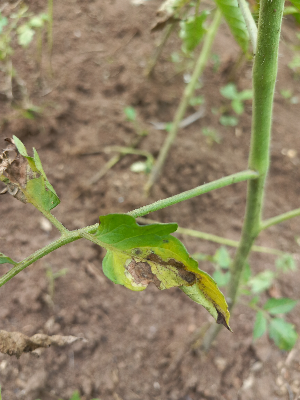

In [4]:
# Print out test image
test_img = '/content/crop-disease-ghana/input/Tomato/Tomato__Early_Blight/images/20230518_134246.jpg'
test_img = cv2.imread(test_img)
#cv2_imshow(test_img)

def display_image(test_img):
    h, w = test_img.shape[0:2]
    neww = 300
    newh = int(neww*(h/w))
    test_img = cv2.resize(test_img, (neww, newh))
    cv2_imshow(test_img)
    cv2.waitKey(0)

display_image(test_img)

In [5]:
# Show files in directory
os.listdir('/content/crop-disease-ghana/input')

['Tomato',
 'Pepper',
 'catyegory_index.pbtxt',
 'label_map.json',
 'dataset_labels.csv',
 'Corn',
 'label_map.txt',
 'label_map.pbtxt']

In [6]:
# Read csv file with data labels
labels_df = pd.read_csv('/content/crop-disease-ghana/input/dataset_labels.csv')
labels_df.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path
0,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2052.653343,695.836619,2210.117161,785.809054,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
1,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1110.682288,901.086237,1228.780152,982.623756,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
2,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1647.746382,912.332791,1791.150930,1002.305226,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
3,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2491.302550,1275.034169,2589.717436,1367.818243,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...
4,20230524_104642.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,3326.423156,1255.352699,3410.778773,1339.701857,input\Corn\Corn__Cercospora_Leaf_Spot\annotati...,input\Corn\Corn__Cercospora_Leaf_Spot\images\2...


In [7]:
# Create new column combining width and height column
labels_df['shape'] = 0
shape_lst = []
for i in range(len(labels_df)):
  shape_lst.append((labels_df['width'][i],labels_df['height'][i]))

labels_df['shape'] = shape_lst
labels_df['shape'].value_counts()

(4032, 3024)    19548
(4080, 1836)    13500
(1920, 1280)    12418
(4080, 3060)     9007
(720, 480)       1473
(4000, 3000)     1123
(6720, 4480)      552
(1920, 2560)      428
(2560, 1920)      210
(2576, 1932)      102
Name: shape, dtype: int64

In [8]:
# Merge similar classes
labels_df.replace(['Pepper Late Blight','Pepper Early Blight'],'Pepper Leaf Blight',inplace = True)
labels_df.replace(['Tomato Late Blight','Tomato Early Blight'],'Tomato Leaf Blight',inplace = True)

In [9]:
# Labels for categories
f = open('/content/crop-disease-ghana/input/label_map.json')
label_json = json.load(f)
label_json

{'Corn Cercospora Leaf Spot': 1,
 'Corn Common Rust': 2,
 'Corn Healthy': 3,
 'Corn Streak': 4,
 'Corn Northern Leaf Blight': 5,
 'Pepper Leaf Curl': 6,
 'Pepper Cercospora': 7,
 'Pepper Leaf Blight': 8,
 'Pepper Bacterial Spot': 9,
 'Pepper Leaf Mosaic': 10,
 'Pepper Healthy': 11,
 'Pepper Fusarium': 12,
 'Pepper Septoria': 13,
 'Pepper Late Blight': 14,
 'Pepper Early Blight': 15,
 'Tomato Late Blight': 16,
 'Tomato Early Blight': 17,
 'Tomato Bacterial Spot': 18,
 'Tomato Septoria': 19,
 'Tomato Fusarium': 20,
 'Tomato Leaf Curl': 21,
 'Tomato Healthy': 22,
 'Tomato Mosaic': 23}

<Axes: xlabel='crop', ylabel='count'>

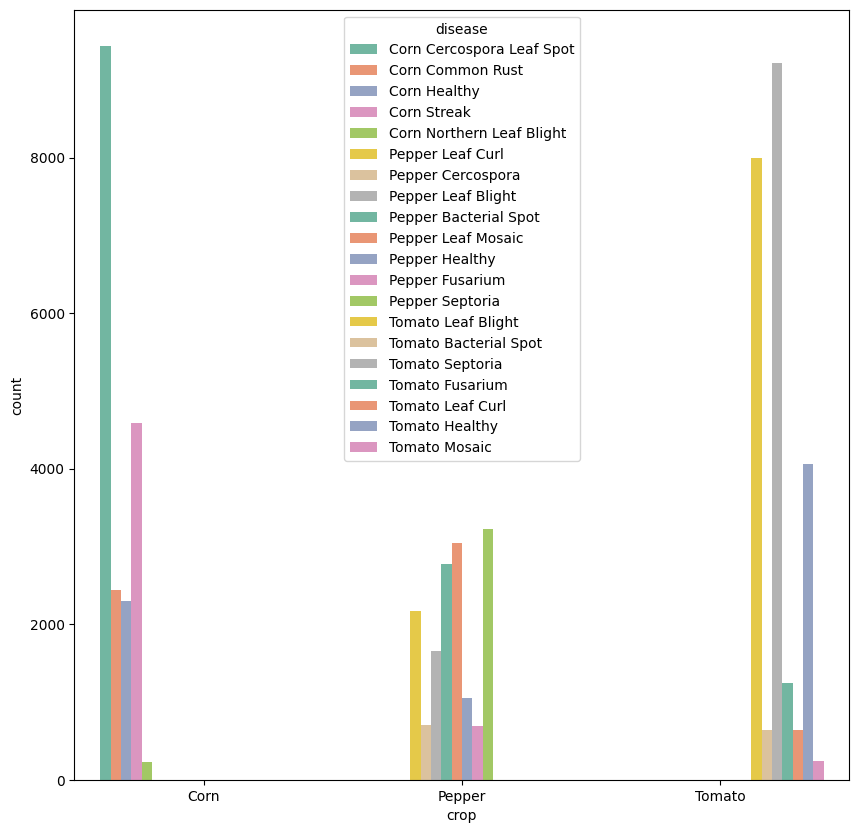

In [10]:
# Crop type and disease distribution
plt.figure(figsize = (10,10))
sns.countplot(x = labels_df['crop'],hue = labels_df['disease'],palette = 'Set2')

In [11]:
# Disease value counts
labels_df['disease'].value_counts()

Corn Cercospora Leaf Spot    9431
Tomato Septoria              9211
Tomato Leaf Blight           7993
Corn Streak                  4591
Tomato Healthy               4066
Pepper Septoria              3222
Pepper Leaf Mosaic           3047
Pepper Bacterial Spot        2780
Corn Common Rust             2434
Corn Healthy                 2304
Pepper Leaf Curl             2175
Pepper Leaf Blight           1660
Tomato Fusarium              1238
Pepper Healthy               1049
Pepper Cercospora             704
Pepper Fusarium               696
Tomato Leaf Curl              641
Tomato Bacterial Spot         639
Tomato Mosaic                 246
Corn Northern Leaf Blight     234
Name: disease, dtype: int64

### Looks like there is class imbalance. In order to address this problem, there should be a combination of resampling and data augmentation.

In [12]:
# Fix img path
loc_path = '/content/crop-disease-ghana/'
new_img = []
for txt in labels_df['img_path']:
  n = loc_path + txt.replace('\\','/')
  new_img.append(n)
labels_df['img_path'] = new_img
labels_df['img_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'

In [13]:
# Fix annotation path
loc_path = '/content/crop-disease-ghana/'
new_ann = []
for txt in labels_df['ann_path']:
  a = loc_path + txt.replace('\\','/')
  new_ann.append(a)
labels_df['ann_path'] = new_ann
labels_df['ann_path'][0]

'/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'

In [14]:
def read_bounding_boxes(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()

  bounding_boxes = []

  for obj in root.findall('.//object'):
      name = obj.find('name').text
      xmin = float(obj.find('.//bndbox/xmin').text)
      ymin = float(obj.find('.//bndbox/ymin').text)
      xmax = float(obj.find('.//bndbox/xmax').text)
      ymax = float(obj.find('.//bndbox/ymax').text)

      bounding_boxes.append({
          'name': name,
          'xmin': xmin,
          'ymin': ymin,
          'xmax': xmax,
          'ymax': ymax
      })

  return bounding_boxes

In [15]:
import xml.etree.ElementTree as ET
xml_file_path='/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/annotations/20230524_104642.xml'
bounding_boxes = read_bounding_boxes(xml_file_path)

for box in bounding_boxes:
    print(f"Name: {box['name']}, Bounding Box: ({box['xmin']}, {box['ymin']}, {box['xmax']}, {box['ymax']})")

Name: Cercospora leaf spot, Bounding Box: (2052.6533425223984, 695.8366194486982, 2210.117160578911, 785.8090543644715)
Name: Cercospora leaf spot, Bounding Box: (1110.682288077188, 901.0862366003063, 1228.7801516195727, 982.6237557427258)
Name: Cercospora leaf spot, Bounding Box: (1647.7463818056513, 912.3327909647779, 1791.1509303928324, 1002.3052258805512)
Name: Cercospora leaf spot, Bounding Box: (2491.302549965541, 1275.0341692189893, 2589.7174362508613, 1367.8182427258805)
Name: Cercospora leaf spot, Bounding Box: (3326.4231564438314, 1255.3526990811638, 3410.7787732598204, 1339.7018568147014)
Name: Cercospora leaf spot, Bounding Box: (877.2984148862853, 1511.2118108728941, 1017.8911095796002, 1592.7493300153137)
Name: Cercospora leaf spot, Bounding Box: (534.2522398345968, 799.8672473200612, 643.9145416953825, 903.8978751914242)
Name: Cercospora leaf spot, Bounding Box: (1847.3880082701585, 1595.5609686064317, 1948.6147484493451, 1677.0984877488513)
Name: Cercospora leaf spot, B

In [16]:
df=labels_df['disease'].value_counts()/15
sorted_disease_counts = df.sort_index()
sorted_disease_counts

Corn Cercospora Leaf Spot    628.733333
Corn Common Rust             162.266667
Corn Healthy                 153.600000
Corn Northern Leaf Blight     15.600000
Corn Streak                  306.066667
Pepper Bacterial Spot        185.333333
Pepper Cercospora             46.933333
Pepper Fusarium               46.400000
Pepper Healthy                69.933333
Pepper Leaf Blight           110.666667
Pepper Leaf Curl             145.000000
Pepper Leaf Mosaic           203.133333
Pepper Septoria              214.800000
Tomato Bacterial Spot         42.600000
Tomato Fusarium               82.533333
Tomato Healthy               271.066667
Tomato Leaf Blight           532.866667
Tomato Leaf Curl              42.733333
Tomato Mosaic                 16.400000
Tomato Septoria              614.066667
Name: disease, dtype: float64

In [17]:
np.unique(labels_df['disease'])

array(['Corn Cercospora Leaf Spot', 'Corn Common Rust', 'Corn Healthy',
       'Corn Northern Leaf Blight', 'Corn Streak',
       'Pepper Bacterial Spot', 'Pepper Cercospora', 'Pepper Fusarium',
       'Pepper Healthy', 'Pepper Leaf Blight', 'Pepper Leaf Curl',
       'Pepper Leaf Mosaic', 'Pepper Septoria', 'Tomato Bacterial Spot',
       'Tomato Fusarium', 'Tomato Healthy', 'Tomato Leaf Blight',
       'Tomato Leaf Curl', 'Tomato Mosaic', 'Tomato Septoria'],
      dtype=object)

In [18]:
# Create balanced dataset
df_balanced = pd.DataFrame(columns = labels_df.columns)
indx=0
for i in np.unique(labels_df['disease']):
  df = labels_df[labels_df['disease']==i]
  samp = df.sample(n = int(sorted_disease_counts[indx]))
  df_balanced = df_balanced.append(samp,ignore_index = True)
  indx=indx+1

<ipython-input-18-5f67aa0d7ee8>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_balanced = df_balanced.append(samp,ignore_index = True)


In [19]:
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape
0,20230526_114851.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2181.132075,826.725641,2309.433962,903.700796,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
1,20230525_111140(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1887.718310,771.464789,1996.901408,860.535211,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
2,20230524_105410.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1369.372846,684.590065,1495.906272,771.750861,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
3,20230525_111431.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,2460.372157,1525.270004,2648.766368,1646.170463,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
4,20230525_111522.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,1313.135768,782.997416,1417.174363,861.723296,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"


In [20]:
df_balanced.shape

(3881, 13)

In [21]:
df_balanced['disease'].value_counts()

Corn Cercospora Leaf Spot    628
Tomato Septoria              614
Tomato Leaf Blight           532
Corn Streak                  306
Tomato Healthy               271
Pepper Septoria              214
Pepper Leaf Mosaic           203
Pepper Bacterial Spot        185
Corn Common Rust             162
Corn Healthy                 153
Pepper Leaf Curl             145
Pepper Leaf Blight           110
Tomato Fusarium               82
Pepper Healthy                69
Pepper Fusarium               46
Pepper Cercospora             46
Tomato Bacterial Spot         42
Tomato Leaf Curl              42
Tomato Mosaic                 16
Corn Northern Leaf Blight     15
Name: disease, dtype: int64

In [22]:
new_xmin = []
new_ymin = []
new_xmax = []
new_ymax = []

for i in range(df_balanced.shape[0]):
  w=df_balanced['width'][i]
  h=df_balanced['height'][i]
  xmin=df_balanced['xmin'][i]
  ymin=df_balanced['ymin'][i]
  xmax=df_balanced['xmax'][i]
  ymax=df_balanced['ymax'][i]
  new_xmin.append(float(xmin) / w)
  new_ymin.append(float(ymin) / h)
  new_xmax.append(float(xmax) / w)
  new_ymax.append(float(ymax) / h)

df_balanced['xmin'] = new_xmin
df_balanced['ymin'] = new_ymin
df_balanced['xmax'] = new_xmax
df_balanced['ymax'] = new_ymax
df_balanced.head()

,filename,disease,crop,width,height,depth,xmin,ymin,xmax,ymax,ann_path,img_path,shape
0,20230526_114851.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.534591,0.450286,0.566038,0.492212,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
1,20230525_111140(0).jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.462676,0.420188,0.489437,0.468701,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
2,20230524_105410.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.335631,0.372870,0.366644,0.420344,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
3,20230525_111431.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.603032,0.830757,0.649207,0.896607,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"
4,20230525_111522.jpg,Corn Cercospora Leaf Spot,Corn,4080,1836,3,0.321847,0.426469,0.347347,0.469348,/content/crop-disease-ghana/input/Corn/Corn__C...,/content/crop-disease-ghana/input/Corn/Corn__C...,"(4080, 1836)"


In [23]:
width=224
height=224
depth= 3
epoch_= 25
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
#root_dir = '/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
INIT_LR = 1e-3


In [24]:
def augment_image_with_bboxes(image, bounding_boxes):
    # Create an ImageDataGenerator with specified augmentation parameters
    aug = ImageDataGenerator(
        rotation_range=25, width_shift_range=0.1,
        height_shift_range=0.1, shear_range=0.2,
        zoom_range=0.2, horizontal_flip=True,
        fill_mode="nearest"
    )

    # Convert the image to a 4D array (batch_size=1)
    image = image.reshape((1,) + image.shape)

    # Create a generator for augmented images
    augmented_images_generator = aug.flow(image, batch_size=1, shuffle=False)

    # Get the augmented image
    augmented_image = next(augmented_images_generator)[0]

    # Extract the augmented image array and convert it back to an image
    augmented_image = img_to_array(augmented_image).astype(np.uint8)

    # Apply the same transformation to the bounding boxes
    augmented_bounding_boxes = []

    #for box in bounding_boxes:
    x_min, y_min, x_max, y_max = bounding_boxes
    points = np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32).reshape((1, 1, 4))
    transform_params = aug.get_random_transform(img_shape=image.shape[1:])
    augmented_points = aug.apply_transform(points, transform_params).reshape(4,)
    augmented_bounding_boxes.append(augmented_points)

    return augmented_image, augmented_bounding_boxes

def convert_image_to_array(image_dir, bounding_boxes):
    try:
        image = cv2.imread(image_dir)
        if image is not None:
            # Resize the image to the default size
            image = cv2.resize(image, default_image_size)

            # Augment the image and bounding boxes
            augmented_image, augmented_bounding_boxes = augment_image_with_bboxes(image, bounding_boxes)

            return augmented_image, augmented_bounding_boxes
        else:
            return np.array([]), []
    except Exception as e:
        print(f"Error: {e}")
        return None, []

In [ ]:
# def convert_image_to_array(image_dir):
#     aug = ImageDataGenerator(
#     rotation_range=25, width_shift_range=0.1,
#     height_shift_range=0.1, shear_range=0.2,
#     zoom_range=0.2,horizontal_flip=True,
#     fill_mode="nearest")

#     try:
#         image = cv2.imread(image_dir)
#         if image is not None :
#             image = cv2.resize(image, default_image_size)
#             image = image.reshape((1,) + image.shape) #New line of code
#             augmented_images=aug.flow(image,batch_size=1) #new line of code
#             augmented_images_array=next(augmented_images)[0] #new line of code
#             #return img_to_array(image)
#             return augmented_images_array
#         else :
#             return np.array([])
#     except Exception as e:
#         print(f"Error : {e}")
#         return None

In [25]:
image_list, label_list, bboxes_list, imagePaths_list = [], [], [], []
indx=0
i=0
try:
  for img_dir in df_balanced['img_path']:
  #for i in range(2):
    #img_dir= f"{root_dir}/{plant_folder}/{plant_disease_folder}/{image}"
    if img_dir.endswith(".jpg") == True or img_dir.endswith(".JPG") == True:
      bndboxes=[]
      bndboxes=(df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx])
      #image_list.append(convert_image_to_array(img_dir))
      augmented_image, augmented_bounding_boxes = convert_image_to_array(img_dir, bndboxes) # New line of code
      image_list.append(augmented_image)# New line of code
      label_list.append(df_balanced['disease'][indx])
      bboxes_list.append(augmented_bounding_boxes)
      imagePaths_list.append(df_balanced['img_path'][indx])
      #bboxes_list.append((df_balanced['xmin'][indx], df_balanced['ymin'][indx], df_balanced['xmax'][indx], df_balanced['ymax'][indx]))

      indx=indx+1
except Exception as e:
  print(f"Error : {e}")

In [26]:
data, labels, bboxes, imagePaths = [], [], [], []
data = np.array(image_list, dtype="float32") / 255.0
labels = np.array(label_list)
bboxes = np.array(bboxes_list, dtype="float32")
imagePaths = np.array(imagePaths_list)

In [27]:
print (data[0], labels[0], bboxes[0], imagePaths[0])

[[[0.         0.54509807 0.36862746]
  [0.         0.53333336 0.35686275]
  [0.         0.5411765  0.3647059 ]
  ...
  [0.2784314  0.6509804  0.54901963]
  [0.26666668 0.63529414 0.5372549 ]
  [0.25882354 0.61960787 0.5254902 ]]

 [[0.         0.54509807 0.36862746]
  [0.         0.53333336 0.35686275]
  [0.         0.5411765  0.3647059 ]
  ...
  [0.27058825 0.5411765  0.48235294]
  [0.28235295 0.5411765  0.4862745 ]
  [0.2901961  0.54509807 0.49019608]]

 [[0.         0.54509807 0.36862746]
  [0.         0.53333336 0.35686275]
  [0.         0.5372549  0.36078432]
  ...
  [0.3019608  0.53333336 0.4745098 ]
  [0.29411766 0.5294118  0.46666667]
  [0.2901961  0.5254902  0.4627451 ]]

 ...

 [[0.09019608 0.2        0.20392157]
  [0.09019608 0.2        0.20392157]
  [0.09019608 0.2        0.20392157]
  ...
  [0.03529412 0.2901961  0.20392157]
  [0.03529412 0.2901961  0.20392157]
  [0.03529412 0.2901961  0.20392157]]

 [[0.09803922 0.2        0.22352941]
  [0.09803922 0.2        0.22352941]


In [28]:
label_binarizer = LabelBinarizer()
if labels is not None:
  binarylabels = label_binarizer.fit_transform(labels)
  pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
  n_classes = len(label_binarizer.classes_)

In [29]:
print(labels.shape)

(2634,)


In [30]:
split = train_test_split(data, binarylabels, bboxes, imagePaths, test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [ ]:
#augimage=[]
#aug_iter=aug.flow(trainImages, batch_size=BS)
#augimage=next(aug_iter)[0].astype('uint8')
#aug_image_count=len(aug_iter) * BS
#for i in range(aug_image_count):
#  augimage.append(next(aug_iter)[0].astype('uint8'))


In [31]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [32]:

# load the VGG16 network, ensuring the head FC layers are left off
vgg = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))
# freeze all VGG layers so they will *not* be updated during the
# training process
vgg.trainable = False
# flatten the max-pooling output of VGG
flatten = vgg.output
flatten = Flatten()(flatten)

In [33]:
# construct a fully-connected layer header to output the predicted
# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",	name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(len(label_binarizer.classes_), activation="softmax", name="class_label")(softmaxHead)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
	inputs=vgg.input,
	outputs=(bboxHead, softmaxHead))

In [34]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
	"class_label": "categorical_crossentropy",
	"bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
	"class_label": 1.0,
	"bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=INIT_LR)
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [35]:
# construct a dictionary for our target training outputs
trainTargets = {
	"class_label": trainLabels,
	"bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
	"class_label": testLabels,
	"bounding_box": testBBoxes
}

In [ ]:
#class_weight_dict = dict(enumerate(class_weights))

In [67]:
unique_labels = np.unique(labels)

# Create a mapping from class labels to integer indices
label_to_index = {label: index for index, label in enumerate(unique_labels)}

# Map your original labels to integer indices
indices = [label_to_index[label] for label in labels]

In [36]:
class_weights = class_weight.compute_class_weight(class_weight= "balanced", classes = np.unique(indices), y= indices)
class_weights

array([ 0.25676752,  0.99537037,  1.05392157, 10.75      ,  0.52696078,
        0.87162162,  3.50543478,  3.50543478,  2.33695652,  1.46590909,
        1.11206897,  0.79433498,  0.75350467,  3.83928571,  1.96646341,
        0.92672414])

In [37]:
class_weights = dict(zip(np.unique(indices), class_weights))
class_weights

{0: 0.2567675159235669,
 1: 0.9953703703703703,
 2: 1.053921568627451,
 3: 10.75,
 4: 0.5269607843137255,
 5: 0.8716216216216216,
 6: 3.505434782608696,
 7: 3.505434782608696,
 8: 2.3369565217391304,
 9: 1.4659090909090908,
 10: 1.1120689655172413,
 11: 0.7943349753694581,
 12: 0.7535046728971962,
 13: 3.8392857142857144,
 14: 1.9664634146341464,
 15: 0.9267241379310345}

In [38]:
#class_weight_dict = {"class_label": dict(enumerate(class_weights))}
#class_weight_dict={"class_label": class_weights}
class_weight_dict=class_weights

In [39]:
class_weights_bbox=None
class_weights_label=None

In [ ]:
#class_weight_dict=dict(enumerate(class_weights))

In [36]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
	trainImages, trainTargets,
	validation_data=(testImages, testTargets),
	batch_size=BS,
	epochs=25,
	verbose=1)

[INFO] training model...
Epoch 1/25
66/66 [==============================] - 24s 129ms/step - loss: 2.8409 - bounding_box_loss: 0.0638 - class_label_loss: 2.7771 - bounding_box_accuracy: 0.4281 - class_label_accuracy: 0.2534 - val_loss: 1.9445 - val_bounding_box_loss: 0.0548 - val_class_label_loss: 1.8897 - val_bounding_box_accuracy: 0.4877 - val_class_label_accuracy: 0.3567
Epoch 2/25
66/66 [==============================] - 5s 76ms/step - loss: 2.1490 - bounding_box_loss: 0.0575 - class_label_loss: 2.0915 - bounding_box_accuracy: 0.4760 - class_label_accuracy: 0.3094 - val_loss: 1.9085 - val_bounding_box_loss: 0.0531 - val_class_label_loss: 1.8554 - val_bounding_box_accuracy: 0.5275 - val_class_label_accuracy: 0.4099
Epoch 3/25
66/66 [==============================] - 5s 76ms/step - loss: 2.0765 - bounding_box_loss: 0.0524 - class_label_loss: 2.0241 - bounding_box_accuracy: 0.5145 - class_label_accuracy: 0.3194 - val_loss: 1.9427 - val_bounding_box_loss: 0.0482 - val_class_label_loss

In [49]:
class_weights = {
    'class_label': class_weights
    },

In [50]:
class_weights

({'class_label': {0: 0.25775450689289503,
   1: 1.0002572016460904,
   2: 1.0567934782608697,
   3: 10.567934782608695,
   4: 0.5295479302832244,
   5: 0.8743255395683454,
   6: 3.4723214285714286,
   7: 3.522644927536232,
   8: 2.337139423076923,
   9: 1.4642319277108433,
   10: 1.1201036866359446,
   11: 0.799547697368421,
   12: 0.7548524844720497,
   13: 3.8581349206349205,
   14: 1.9761178861788617,
   15: 0.8838636363636364}},)

In [ ]:
# # Manually apply class weights to classification loss
# for epoch in range(25):
#     print("[INFO] training model - Epoch: ", epoch)
#     # loop over all batches of the dataset
#     for (images, targets) in zip(trainImages, zip(trainLabels, trainBBoxes)):
#         # separate the bounding box targets from the classification targets
#         targets_class, targets_bbox = targets
#         print(targets_class)
#         print(targets_bbox)

#         # compute the class weights
#         class_weights_classification = class_weights
#         sample_weights_class = np.array([class_weights_classification[np.argmax(target)] for target in targets_class])
#         print(sample_weights_class)
#         # train the network
#         loss = model.train_on_batch(images, {"class_label": targets_class, "bounding_box": targets_bbox}, sample_weight={"class_label": sample_weights_class, "bounding_box": None})

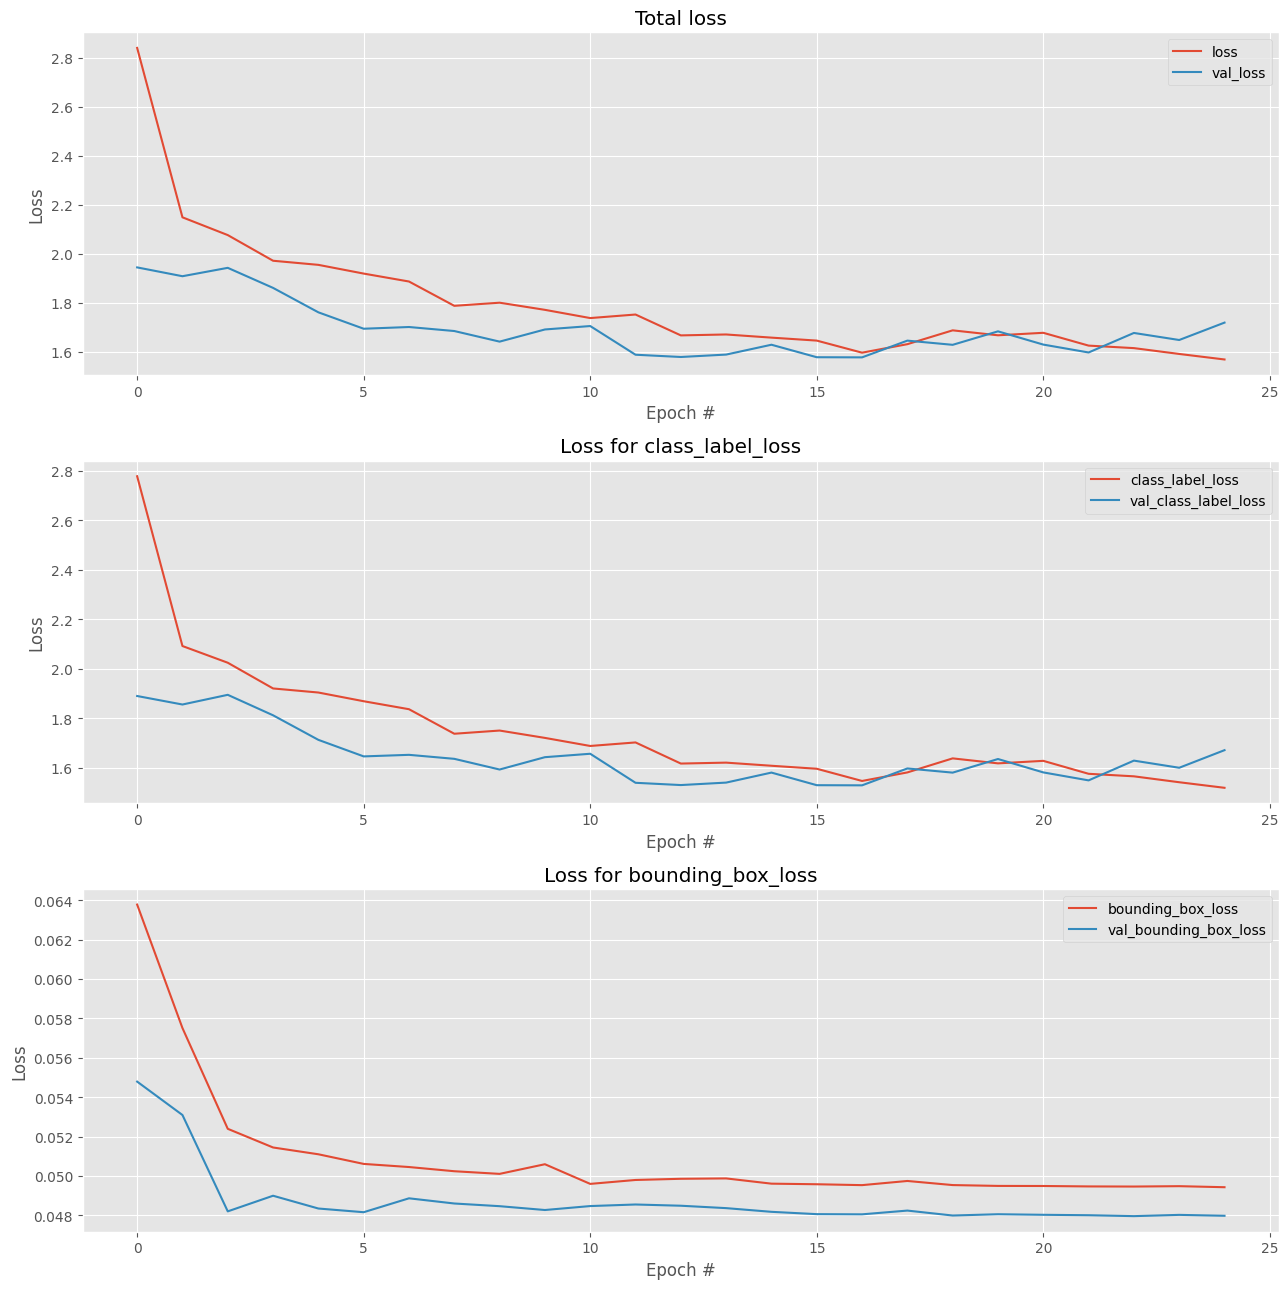

In [37]:
# plot the total loss, label loss, and bounding box loss
epochs=25
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, epochs)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	ax[i].set_title(title)
	ax[i].set_xlabel("Epoch #")
	ax[i].set_ylabel("Loss")
	ax[i].plot(N, H.history[l], label=l)
	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
	ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()

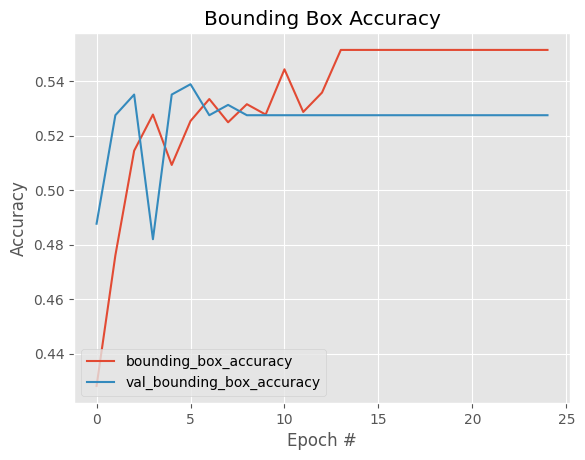

In [38]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
	label="bounding_box_accuracy")
plt.plot(N, H.history["val_bounding_box_accuracy"],
	label="val_bounding_box_accuracy")
plt.title("Bounding Box Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


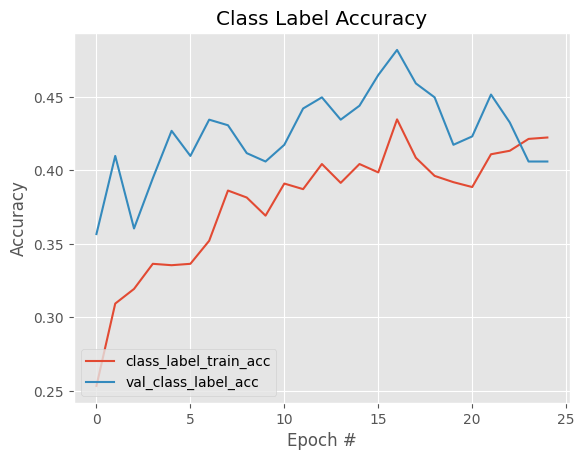

In [39]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
	label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
	label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")


In [40]:
img = '/content/crop-disease-ghana/input/Corn/Corn__Cercospora_Leaf_Spot/images/20230524_104642.jpg'
#img = '/content/crop-disease-ghana/input/Tomato/Tomato__Septoria/images/2N8A0600.JPG'

In [42]:
# loop over the images that we'll be testing using our bounding box
# regression model
#for imagePath in imagePaths:
	# load the input image (in Keras format) from disk and preprocess
	# it, scaling the pixel intensities to the range [0, 1]

image = load_img(img, target_size=(224, 224))
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
# predict the bounding box of the object along with the class
# label
(boxPreds, labelPreds) = model.predict(image)
(startX, startY, endX, endY) = boxPreds[0]
# determine the class label with the largest predicted
# probability
i = np.argmax(labelPreds, axis=1)
label = label_binarizer.classes_[i][0]

1/1 [==============================] - 0s 415ms/step


In [43]:
print(startX, startY, endX, endY)

0.46248478 0.46774912 0.54403764 0.5829622


In [44]:
print(label)

Corn Common Rust


184 280 217 349


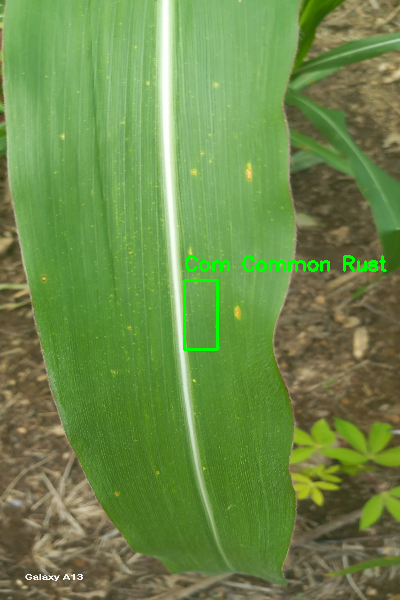

-1

In [45]:
# load the input image (in OpenCV format), resize it such that it
# fits on our screen, and grab its dimensions
from imutils import paths

image = cv2.imread(img)
image = image.copy()
image = cv2.resize(image, (400, 600))
#image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]
# scale the predicted bounding box coordinates based on the image
# dimensions
startX = int(startX * w)
startY = int(startY * h)
endX = int(endX * w)
endY = int(endY * h)
print(startX, startY, endX, endY)
# draw the predicted bounding box and class label on the image
y = startY - 10 if startY - 10 > 10 else startY + 10
cv2.putText(image, label, (startX, y), cv2.FONT_HERSHEY_SIMPLEX,0.65, (0, 255, 0), 2)
cv2.rectangle(image, (startX, startY), (endX, endY), (0, 255, 0), 2)
# show the output image
cv2_imshow(image)
cv2.waitKey(0)

In [46]:
scores = model.evaluate(testImages, testTargets)
print(f"Test Bounding Box Accuracy: {scores[3]*100}")
print(f"Test Class Label Accuracy: {scores[4]*100}")

17/17 [==============================] - 1s 48ms/step - loss: 1.7190 - bounding_box_loss: 0.0480 - class_label_loss: 1.6711 - bounding_box_accuracy: 0.5275 - class_label_accuracy: 0.4061
Test Bounding Box Accuracy: 52.75142192840576
Test Class Label Accuracy: 40.607210993766785


In [47]:
pred_test=model.predict(testImages)

17/17 [==============================] - 1s 44ms/step


In [48]:

# Reshape to remove the redundant dimension
converted_coordinates = testBBoxes.reshape((testBBoxes.shape[0], testBBoxes.shape[2]))

print(converted_coordinates)

[[0.16771288 0.40454927 0.39862174 0.6866769 ]
 [0.64410263 0.67163235 0.7145391  0.72560817]
 [0.26971832 0.4405321  0.2915493  0.49374023]
 ...
 [0.01929704 0.7695013  0.05099931 0.8215687 ]
 [0.6249079  0.6175583  0.64627856 0.6552015 ]
 [0.50844216 0.62091494 0.5740017  0.7993508 ]]


In [49]:
from sklearn.metrics import mean_squared_error

mse_bbox = mean_squared_error(converted_coordinates, pred_test[0])

In [50]:
print(f"Test Bounding Box Mean Square Error: {mse_bbox*100}")

Test Bounding Box Mean Square Error: 4.797755181789398


In [51]:
threshold = 0.5
binary_predictions = (pred_test[1] > threshold).astype(int)

In [52]:
# accuracy: (tp + tn) / (p + n)
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

f1_test = f1_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications F1 score: {f1_test*100}")
accuracy = accuracy_score(testLabels, binary_predictions)
print(f"Test Classifications accracy: {accuracy*100}")
# precision tp / (tp + fp)
precision = precision_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications precision: {precision*100}")
# recall: tp / (tp + fn)
recall = recall_score(testLabels, binary_predictions, average='micro')
print(f"Test Classifications recall: {recall*100}")

Test Classifications F1 score: 38.55755894590846
Test Classifications accracy: 26.37571157495256
Test Classifications precision: 71.64948453608247
Test Classifications recall: 26.37571157495256
